In [2]:
from utils import (
    sig,
    sigfit,
    adj_rmse,
    TwoFlashesProcessingStrategy,
    TwoFlashesProcessingStrategy_Explore,
)

## Experimental Data

In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


<Axes: xlabel='Delay', ylabel='Flashes (%)'>

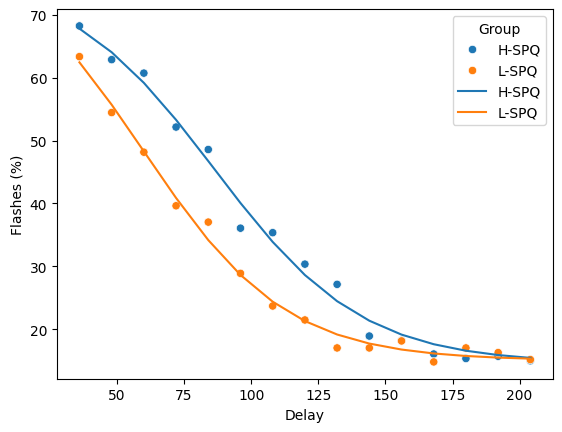

In [4]:
import seaborn as sns

sns.scatterplot(data=dataset, x="Delay", y="Flashes (%)", hue="Group")
sns.lineplot(data=dataset, x="Delay", y="Fit", hue="Group")

<Axes: xlabel='Delay', ylabel='Fit'>

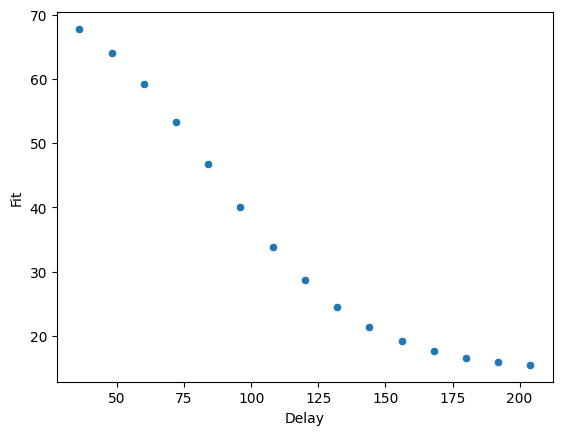

In [5]:
# Data to fit
hspq_data = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Delay"].values
sns.scatterplot(data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay")

## Fitting

In [ ]:
from skneuromsi.neural import Paredes2025
from skneuromsi.sweep import ParameterSweep
from scipy.optimize import differential_evolution
import numpy as np


def two_flashes_job(cm_weight):

    model = Paredes2025(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(6.560e00, 9.191e00, 1.200e02),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=1,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=0.5,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=6.231e-01,
        feedforward_weight=3.892e00,
    )

    return res


def hspq_cost(theta):

    exp_data = hspq_data
    model_data = two_flashes_job(cm_weight=theta[0])
    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(0, 0.04)]

hspq_fit_res = differential_evolution(
    hspq_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=30,
    polish=False,
)

differential_evolution step 1: f(x)= 0.49767591390687554
differential_evolution step 2: f(x)= 0.49767591390687554


In [17]:
print(hspq_fit_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 0.49767591390687554
                   x: [ 3.995e-02]
                 nit: 2
                nfev: 45
          population: [[ 3.995e-02]
                       [ 3.359e-02]
                       ...
                       [ 3.891e-02]
                       [ 3.509e-02]]
 population_energies: [ 4.977e-01  5.010e-01 ...  4.983e-01  5.004e-01]


## Exploration

In [ ]:
from skneuromsi.neural import Paredes2025
from skneuromsi.sweep import ParameterSweep
import numpy as np


def two_flashes_job(cm_weight):

    model = Paredes2025(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(6.560e00, 9.191e00, 1.200e02),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy_Explore(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=0.5,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=6.231e-01,
        feedforward_weight=3.892e00,
    )

    return res


results_list, two_flashes_res, _ = two_flashes_job(cm_weight=3.995e-02)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
sig_soas = np.linspace(soas[0], soas[-1], endpoint=True, num=100)
a, b, c, d = sigfit(soas, two_flashes_res)
print(a, b, c, d)
fb_model_data = sig(sig_soas, a, b, c, d)

15.877702701706664 54.60101030738361 71.33690203845785 -20.313551567033937


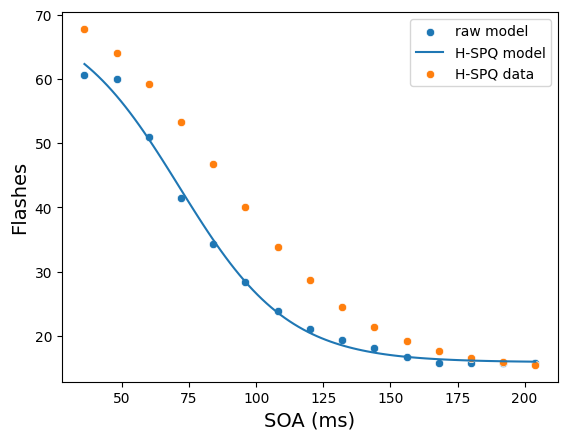

In [8]:
import matplotlib.pyplot as plt

sns.scatterplot(x=soas, y=two_flashes_res, label="raw model")
sns.lineplot(x=sig_soas, y=fb_model_data, label="H-SPQ model")
sns.scatterplot(
    data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay", label="H-SPQ data"
)
plt.ylabel("Flashes", size=14)
plt.xlabel("SOA (ms)", size=14)
plt.show()

In [9]:
scz_error = adj_rmse(two_flashes_res, hspq_data, 1)
print(scz_error)

7.43149983527872
